In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable - -py widgetsnbextension

In [ ]:
# аугментации изображений
!pip install albumentations - q

In [ ]:
pip install pymorphy2

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import sys
import PIL
import cv2
import re

In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
# фиксируем RANDOM_SEED, чтобы наши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

#1. Наивная модель

Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.

In [ ]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# 2. CatboostRegressor

In [ ]:
# загрузим тренировочные и тестовые данные
train = pd.read_csv("train_catboost_1_.csv")
test = pd.read_csv("test_catboost_1_.csv")

In [ ]:
y = train.price.values     # наш таргет
X = train.drop(['price'], axis=1)

In [ ]:
cat_features_ = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
                 'name', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# CATBOOST
ITERATIONS = 6000

In [ ]:
model = CatBoostRegressor(iterations=ITERATIONS,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          # task_type='GPU',
                          )
model.fit(X_train, y_train,
          cat_features=cat_features_,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True
          )

Learning rate set to 0.020953


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0419827	test: 0.0420389	best: 0.0420389 (0)	total: 33.5ms	remaining: 3m 21s
100:	learn: 0.0136576	test: 0.0133872	best: 0.0133872 (100)	total: 1.96s	remaining: 1m 54s
200:	learn: 0.0106691	test: 0.0104719	best: 0.0104719 (200)	total: 3.68s	remaining: 1m 46s
300:	learn: 0.0098685	test: 0.0097538	best: 0.0097538 (300)	total: 5.46s	remaining: 1m 43s
400:	learn: 0.0094062	test: 0.0093828	best: 0.0093828 (400)	total: 7.14s	remaining: 1m 39s
500:	learn: 0.0090253	test: 0.0091096	best: 0.0091096 (500)	total: 8.9s	remaining: 1m 37s
600:	learn: 0.0087176	test: 0.0089106	best: 0.0089106 (600)	total: 10.7s	remaining: 1m 36s
700:	learn: 0.0084881	test: 0.0087544	best: 0.0087542 (699)	total: 12.6s	remaining: 1m 35s
800:	learn: 0.0083280	test: 0.0086561	best: 0.0086561 (800)	total: 14.4s	remaining: 1m 33s
900:	learn: 0.0081632	test: 0.0085516	best: 0.0085516 (900)	total: 16.4s	remaining: 1m 32s
1000:	learn: 0.0080131	test: 0.0084615	best: 0.0084612 (996)	total: 18.3s	remaining: 1m 31s
11

In [ ]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost))*100:0.2f}%")

TEST mape: 11.41%


In [ ]:
predicts = np.exp(model.predict(test))
predicts = (predicts // 1000) * 1000
sample_submission['price'] = predicts
sample_submission.to_csv('catboost_submission.csv', index=False)

Посмотрим на распределение важности признаков:

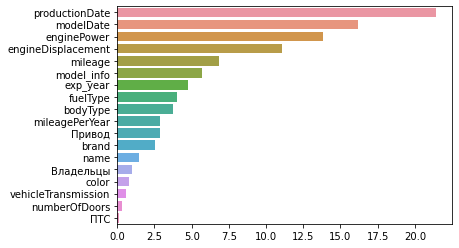

In [ ]:
idx = np.flip(np.argsort(model.feature_importances_))
sns.barplot(x=model.feature_importances_[
            idx[:]], y=np.array(model.feature_names_)[idx[:]])

Видно, что самыми значимыми признаками являются возаст автомобиля, мощность и объем двигателя, а также пробег. Кроме того, вновь сгенерированные фичи (exp_year и mileagePerYear) находятся в середине списка важности, что говорит о том, что они не так уж плохи. Первые пять экспериментов (тестировалось влияние округления цены на результат, а также логарифмирование некоторых числовых признаков) показали, что лучшее значение метрики даёт модель с округлением цены и её логарифмированием. 



In [ ]:
print(
    f"Точность модели CatboostRegressor по метрике MAPE на лидерборде: {12.189:0.3f}%, на тесте: {11.41:0.3f}%")

Точность модели CatboostRegressor по метрике MAPE на лидерборде: 12.189%, на тесте: 11.410%


# 2. Tabular NN

In [ ]:
# загрузим тренировочные и тестовые данные
train = pd.read_csv("train_nn.csv")
test = pd.read_csv("test_nn.csv")

In [ ]:
train.shape, test.shape

((6682, 422), (1671, 421))

In [ ]:
y = np.exp(train.price.values)
X = train.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# построим простую нейронную сеть
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               216064    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 347,649
Trainable params: 347,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                    )

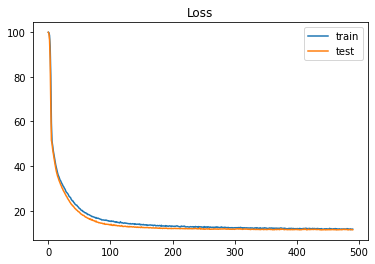

In [ ]:
plt.title('Loss')
train_curve, = plt.plot(history.history['MAPE'], label='train')
test_curve, = plt.plot(history.history['val_MAPE'], label='test')
plt.legend(handles=[train_curve, test_curve])
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

In [ ]:
test_predict_nn = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn[:,0]))*100:0.2f}%")

TEST mape: 11.40%


In [ ]:
predicts = model.predict(test)
predicts = (predicts // 1000) * 1000
sample_submission['price'] = predicts[:, 0]
sample_submission.to_csv('nn_submission.csv', index=False)

In [ ]:
print(
    f"Точность модели Tabular NN по метрике MAPE на лидерборде: {11.517:0.3f}%, на тесте: {11.42:0.3f}%")

Точность модели Tabular NN по метрике MAPE на лидерборде: 11.517%, на тесте: 11.420%


Стоит отметить, что попытки применить другие архитектуры сетей (512, 256, 128) и (1024, 512, 256, 128) не привели к улучшению метрики. Интересный факт: и catboost и tabular NN дали практическое одинаковое качество на тесте при обучении, но нейросеть при этом показала значительно лучшее качество на лидерборде.


# Multi-input (text+tabular)

In [ ]:
# загрузим тренировочные и тестовые данные, а также описание автомобилей (уже очищенное при 2 итерации)
train = pd.read_csv("train_nn.csv")
test = pd.read_csv("test_nn.csv")
desc = pd.read_csv("description_union_clean.csv")

In [ ]:
y = np.exp(train.price.values)
X = train.drop(['price'], axis=1)

In [ ]:
X.index = np.arange(1671, 8353)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# split данных
text_train = desc.description.iloc[X_train.index]
text_test = desc.description.iloc[X_test.index]
text_sub = desc.description.iloc[test.index]

In [ ]:
desc.description

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес тюнинг hamman ез...
2       машина продаваться первый перебрать двигатель ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер 2017 г третий владеле...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние 3из авто семья о...
8352    удлинённый заводский pullman база w140 вообщет...
Name: description, Length: 8353, dtype: object

In [ ]:
% % time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(desc.description)

CPU times: user 941 ms, sys: 2.4 ms, total: 944 ms
Wall time: 945 ms


In [ ]:
% % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape)

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 858 ms, sys: 599 µs, total: 858 ms
Wall time: 859 ms


RNN NLP net

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

MLP net

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

Multiple Inputs net

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)
model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 256, 256)     8240384     seq_description[0][0]            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 256, 256)     525312      embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256)     0           lstm_4[0][0]                     
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=[
                             'val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 8s 407ms/step - loss: 99.9978 - MAPE: 99.9978 - val_loss: 99.9108 - val_MAPE: 99.9108
Epoch 2/500
12/12 [==============================] - 4s 370ms/step - loss: 99.5227 - MAPE: 99.5227 - val_loss: 95.2868 - val_MAPE: 95.2868
Epoch 3/500
12/12 [==============================] - 4s 346ms/step - loss: 89.4139 - MAPE: 89.4139 - val_loss: 55.7455 - val_MAPE: 55.7455
Epoch 4/500
12/12 [==============================] - 4s 338ms/step - loss: 53.8498 - MAPE: 53.8498 - val_loss: 50.2842 - val_MAPE: 50.2842
Epoch 5/500
12/12 [==============================] - 4s 345ms/step - loss: 48.5118 - MAPE: 48.5118 - val_loss: 45.8579 - val_MAPE: 45.8579
Epoch 6/500
12/12 [==============================] - 4s 348ms/step - loss: 44.3092 - MAPE: 44.3092 - val_loss: 41.4501 - val_MAPE: 41.4501
Epoch 7/500
12/12 [==============================] - 4s 350ms/step - loss: 41.2840 - MAPE: 41.2840 - val_loss: 37.9950 - val_MAPE: 37.9950
Epoch 8/500
12/12 [========

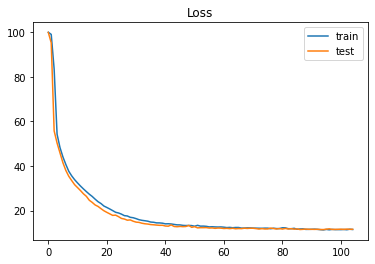

In [ ]:
plt.title('Loss')
train_curve, = plt.plot(history.history['MAPE'], label='train')
test_curve, = plt.plot(history.history['val_MAPE'], label='test')
plt.legend(handles=[train_curve, test_curve])
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.61%


In [ ]:
predicts = model.predict([text_sub_sequences, test])
predicts = (predicts // 1000) * 1000
sample_submission['price'] = predicts[:, 0]
sample_submission.to_csv('nn_nlp_submission.csv', index=False)

In [ ]:
import string

Попробуем почистить текст

In [ ]:
desc = pd.read_csv("description_union.csv")

In [ ]:
desc["new"] = desc["description"].str.lower()

In [ ]:
# удалим пунктуацию
PUNCT_TO_REMOVE = string.punctuation


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


desc["new"] = desc["new"].apply(lambda text: remove_punctuation(text))

In [ ]:
# заменим некоторые символы
replace_list = ['•', '—', '☑️', '✔', '➥', '●',
                '✅', '☛', '———————————————————————————', '\n']


def replace_symbols(text):
    for symbol in replace_list:
        text = text.replace(symbol, ' ')
    return text.strip()


desc["new"] = desc["new"].apply(lambda text: replace_symbols(text))

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# удалим стоп-слова
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in russian_stopwords])


desc["new"] = desc["new"].apply(lambda text: remove_stopwords(text))

In [ ]:
import pymorphy2
# приведем слова в нормальную форму
morph = pymorphy2.MorphAnalyzer()


def lemmatize_words(text):
    return " ".join([morph.parse(word)[0].normal_form for word in text.split()])


desc["new"] = desc["new"].apply(lambda text: lemmatize_words(text))

In [ ]:
desc["description"] = desc["new"]

In [ ]:
desc.drop(["new"], axis=1, inplace=True)

In [ ]:
desc.loc[desc.description.apply(len) == 0, "description"] = "нет описания"

In [ ]:
# сохраним очищенный датасет с описаниями автомобилей
desc.to_csv("description_union_clean.csv", index=False)

Результаты применения сети таковы: 

In [ ]:
print(
    f"Точность модели Multi-input (text+tabular) без обработки текста по метрике MAPE на лидерборде: {12.0:0.3f}%, на тесте: {11.9:0.3f}%")

Точность модели Multi-input (text+tabular) без обработки текста по метрике MAPE на лидерборде: 12.000%, на тесте: 11.900%


In [ ]:
print(
    f"Точность модели Multi-input (text+tabular) с обработкой текста по метрике MAPE на лидерборде: {11.71:0.3f}%, на тесте: {11.61:0.3f}%")

Точность модели Multi-input (text+tabular) с обработкой текста по метрике MAPE на лидерборде: 11.710%, на тесте: 11.610%


Модель Multi-input (text+tabular) не позволила добиться улучшения результата по сравнению с моделью Tabular NN. Возможно, это связано с тем, что текст объявления не репрезентативен с точки зрения предсказания стоимости авто в нашем случае. Однако дополнительная обработка текста позволила немного улучшить результат. 

# Multi-input (text+tabular+images)

При построении сети с добавлением картинок в colab возникли сложности с нехваткой оперативной памяти, поэтому этот этап был выполнен в kaggle. Для сохранения целостности и единообразия, код из kaggle был скопирован в данный ноутбук. 

In [ ]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train_data = pd.read_csv(DATA_DIR + 'train.csv')

In [ ]:
# загрузим тренировочные и тестовые данные, а также описание автомобилей
train = pd.read_csv("../input/bat-data/train_nn.csv")
test = pd.read_csv("../input/bat-data/test_nn.csv")
desc = pd.read_csv("../input/bat-data/description_union_clean.csv")

In [ ]:
y = np.exp(train.price.values)
X = train.drop(['price'], axis=1)

In [ ]:
X.index = np.arange(1671, 8353)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
size = (320, 240)


def get_image_array(index):
    images_train = []
    all = len(index)
    for index, sell_id in enumerate(desc['sell_id'].iloc[index].values):
        if (index+1) % 500 == 0:
            print(index+1, "/", all)
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(test.index)

In [ ]:
import albumentations
from albumentations import (HorizontalFlip, Rotate, RandomBrightnessContrast,
                            GaussianBlur, HueSaturationValue, RGBShift, FancyPCA
                            )

augmentation = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=20, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
])

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[100])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(desc.description)

In [ ]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, desc.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, desc.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(test))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, test, desc.description.iloc[test.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

Сеть #1

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
tabular_model.add(L.Dropout(0.5))
tabular_model.add(L.Dense(256, activation="relu"))
tabular_model.add(L.Dropout(0.5))

In [ ]:
# NLP
nlp_model = Sequential()
nlp_model.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
nlp_model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
nlp_model.add(L.LSTM(256, return_sequences=True))
nlp_model.add(L.Dropout(0.5))
nlp_model.add(L.LSTM(128,))
nlp_model.add(L.Dropout(0.25))
nlp_model.add(L.Dense(64, activation="relu"))
nlp_model.add(L.Dropout(0.25))

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])
# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(128, activation="relu")(head)
head = L.Dense(1,)(head)
model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)

Сеть #2

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB7(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [ ]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
tabular_model.add(L.Dropout(0.5))
tabular_model.add(L.Dense(256, activation="relu"))
tabular_model.add(L.Dropout(0.5))

In [ ]:
# NLP
nlp_model = Sequential()
nlp_model.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
nlp_model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
nlp_model.add(L.LSTM(256, return_sequences=True))
nlp_model.add(L.Dropout(0.5))
nlp_model.add(L.LSTM(128,))
nlp_model.add(L.Dropout(0.25))
nlp_model.add(L.Dense(64, activation="relu"))

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])
# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)
model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)

Как можно видеть, что сети отличаются тем, что для анализа изображений первая использует EfficientNetB6, а вторая EfficientNetB7. Кроме того, "голова" первой сети содержит дополнительный скрытый слой в 128 нейронов, в отличии от второй, где "голова" содержит лишь один слой в 256 нейронов. 

In [3]:
print(
    f"Точность модели Multi-input (text+tabular+images) #1 по метрике MAPE на лидерборде: {12.18:0.3f}%, на тесте: {12.00:0.3f}%")

Точность модели Multi-input (text+tabular+images) #1 по метрике MAPE на лидерборде: 12.180%, на тесте: 12.000%


In [4]:
print(
    f"Точность модели Multi-input (text+tabular+images) #2 по метрике MAPE на лидерборде: {12.18:0.3f}%, на тесте: {12.00:0.3f}%")

Точность модели Multi-input (text+tabular+images) #2 по метрике MAPE на лидерборде: 12.180%, на тесте: 12.000%


# Pivot table

Для наглядности построим сводную таблицу результатов вычислительных экспериментов. Введем краткие обозначения моделей:


*   наивная модель - **naive**
*   catboostregressor - **cat_boost**
*   tabular nn - **tab_nn**
*   multi-input (text+tabular) - **tab_nn+txt**
*   multi-input (text+tabular) c обработкой текста - **tab_nn+txt_proc**
*   multi-input (text+tabular_images) #1 - **tab_nn+txt+image1**
*   multi-input (text+tabular_images) #2 - **tab_nn+txt+image2**

In [32]:
columns_names = ["method", "test", "kaggle"]
data = [("naive", 19.88, None),
        ("cat_boost", 11.41, 12.19),
        ("tab_nn", 11.42, 11.51),
        ("tab_nn+text", 11.90, 12.00),
        ("tab_nn+text_proc", 11.61, 11.71),
        ("tab_nn+text+image1", 12.01, 12.18),
        ("tab_nn+text+image2", 11.96, 12.14),
        ]

In [33]:
table = pd.DataFrame(data, columns=columns_names, index=range(1, 8))
table.sort_values(by="kaggle")

,method,test,kaggle
3,tab_nn,11.42,11.51
5,tab_nn+text_proc,11.61,11.71
4,tab_nn+text,11.90,12.00
7,tab_nn+text+image2,11.96,12.14
6,tab_nn+text+image1,12.01,12.18
2,cat_boost,11.41,12.19
1,naive,19.88,NaN


Из сводной табицы следует, что наилучшим результатом на Kaggle является результат, полученный с помощью простой нейросети на табличных данных. Худший результат показал наивный подход (по test). К сожалению, добавление таких даных как текст и картинки в нейросетевые  модели не дал значительного прироста качества по сравнению с catboost моделью. 

# Blending 

Один из подходов улучшения работы нескольких моделей - это усреднение (блендинг) их предсказаний. Результаты этого подхода сильно зависят от природы моделей, на основе которых получены усредняемые результаты. В нашем случае наиболее разнородными являются нейросетевые модели и catboost, поэтому попробуем усреднить их предсказания

In [ ]:
cat = pd.read_csv("catboost_submission.csv")
nn = pd.read_csv("nn_submission.csv")
nn_nlp = pd.read_csv("nn_nlp_submission.csv")
nn_all = pd.read_csv("nn_all_submission.csv")

In [ ]:
new_price = (cat["price"] + nn_nlp["price"])/2
new_price = (new_price // 1000) * 1000

In [ ]:
cat["price"] = new_price

In [ ]:
cat.to_csv("blend_cat_nn_nlp.csv", index=False)

In [ ]:
pd.read_csv("blend_cat_nn_nlp.csv")

In [24]:
columns_names = ["method", "kaggle"]
data = [("cat_boost+tab_nn", 11.22),
        ("cat_boost+(tab_nn+text+image)", 11.32),
        ("cat_boost+(tab_nn+text)", 11.19),
        ("cat_boost+(tab_nn+text)+(tab_nn)", 11.11)
        ]

In [25]:
table = pd.DataFrame(data, columns=columns_names, index=range(1, 5))
table.sort_values(by="kaggle")

,method,kaggle
4,cat_boost+(tab_nn+text)+(tab_nn),11.11
3,cat_boost+(tab_nn+text),11.19
1,cat_boost+tab_nn,11.22
2,cat_boost+(tab_nn+text+image),11.32


Как видно из таблицы, лучшим результатом является усреднение предсказний моделей catboost, нейросети на табличных данных и нейросети, объединяющей текст и табличные данные. **11.11** - это лучший результат, которого удалось достичь в ходе экспериментов.  